#### Méthodologie d'acquisition des données de pesée globale adoptée lors du sprint :
* prendre tous les flux toflit avec le flag best_guess_national_partner pour établir les totaux pour toute la france
* prendre tous les flux toflit avec le flag best_guess_region_prodxpart pour établir les totaux par région

#### Ajustements post-sprint : tester sans la traite
* exclure tous les flux avec pour produit "êtres humains" "traite" ??? => on n'a rien de tout ça dans les produits toflit
=> fonctionner avec partner = colonies et aviser en fonction de l'origine du produit ??
(je regarde ce tableau qui m'indique que cette technique ne semble pas fonctionner pour les exports : https://docs.google.com/spreadsheets/d/1ChDCPYVhL3E7MgWMXuFQppKiLUPHuaxD48kAF--Tmmo/edit#gid=1433939378)

pour les imports : tests à la fin de ce noebook => on n'a pas les origines des produits, et la nature des produits commercés avec les colonies ne semble pas mentionner la traite 


==> je dois fonctionner avec des données Navigo pour identifier des activités de traite ?

In [1]:
from poitousprint import Toflit
from vega import VegaLite
import pandas as pd

toflit_client = Toflit()

In [2]:
flows = toflit_client.get_flows(best_guess_region_prodxpart='1')

In [3]:
flows_national = toflit_client.get_flows(best_guess_national_partner='1')

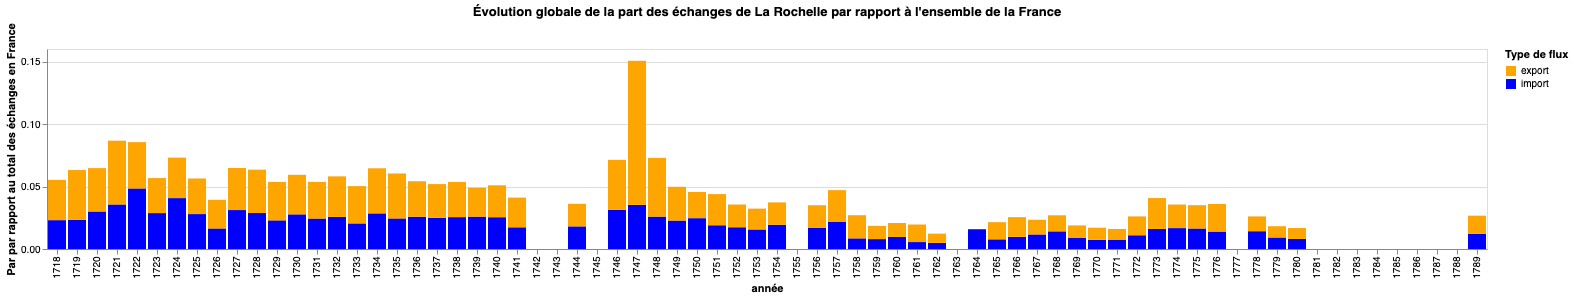

In [11]:
years_list = [y + 1712 for y in range(120)]
years = {}
partner_for_imports = set()
origin_for_imports = set()
products_imported_from_colonies = set()

for y in years_list:
    years[str(y)] = {
        "year": y,
        "france_total": 0,
        "france_export": 0,
        "france_import": 0,
        
        "la_rochelle_total": 0,
        "la_rochelle_export": 0,
        "la_rochelle_import": 0,
    }


for f in flows_national:
    year = str(f['year'].split('.')[0])
    value = float(f['value']) if f['value'] != '' else 0
    itype = f['export_import'] if f['export_import'] != 'import' else 'Imports'

    detailed_field = 'france_import' if itype == 'Imports' else 'france_export'
    years[year]['france_total'] += value        
    years[year][detailed_field] += value

    
for f in flows:
    year = str(f['year'].split('.')[0])
    value = float(f['value']) if f['value'] != '' else 0
    itype = f['export_import'] if f['export_import'] != 'import' else 'Imports'
    from_larochelle = f['customs_region'] == 'La Rochelle'
    if from_larochelle:
        detailed_field = 'la_rochelle_import' if itype == 'Imports' else 'la_rochelle_export'
        years[year]['la_rochelle_total'] += value        
        years[year][detailed_field] += value
    if itype == 'Imports':
        partner_for_imports.add(f['partner_simplification'])
        origin_for_imports.add(f['origin_origin'])
        if f['partner_orthographic'] in ["Sénégal", "Saint-Domingue", "Amérique"]:
            products_imported_from_colonies.add(f['product_simplification'])

part_by_year = []
for year, values in years.items():
    part_by_year.append({
        "year": year,
        "type": "import",
        "portion": values['la_rochelle_import'] / values['france_total'] if  values['france_total'] > 0 else 0
    })
    part_by_year.append({
        "year": year,
        "type": "export",
        "portion": values['la_rochelle_export'] / values['france_total'] if  values['france_total'] > 0 else 0
    })
    """

    part_by_year.append({
        "year": year,
        "type": "reste de la France",
        "portion": 1 - values['la_rochelle_total'] / values['france_total'] if  values['france_total'] > 0 else 0
    })
    """
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Évolution globale de la part des échanges de La Rochelle par rapport à l'ensemble de la France",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "year",
            "type": "ordinal", 
            "title": "année"
        },
        "y": {
            "type": "quantitative",
            "field": "portion",
            "title": "Par par rapport au total des échanges en France"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de flux",
            "scale": {
                "range": ["orange", "blue", "white"]
            }
        }
    }
}, pd.DataFrame([y for y in part_by_year if int(y['year']) > 1717 and int(y['year']) < 1790]))


In [12]:
products_imported_from_colonies

{'agrès',
 'ancres de fer',
 'avirons de bois',
 'baleine coupée',
 'baleine en fanon',
 'barres de fer',
 'blanc de baleine',
 'bois de Campêche',
 'bois pour construction',
 'brai et goudron',
 'chandelle de suif',
 'choix de bœuf salé',
 'cire jaune',
 'cire verte',
 'cou salé',
 'cuirs en poil de vache',
 'douelles pour tonneau',
 'farine',
 'feuilles de tabac',
 'futailles vides',
 'graine de lin',
 'grains ails',
 'grains froment',
 'grains riz',
 'huile de baleine',
 'huile de lin',
 'huile de morue',
 'indigo',
 'jambon',
 "marchandises à l'estimation",
 'merrains',
 'merrains pour tonnellerie',
 'meules à faire',
 'mitrailles de cuivre',
 'morue sèche',
 'mâts de sapin',
 'ouvrages de fer et ouvrages de jonc',
 'peaux de daim',
 'pelleterie',
 'piment',
 'poisson salé',
 'quincaillerie',
 'suif',
 'suif soudes',
 'toile pour voile'}

In [9]:
origin_for_imports

{'', 'Flandre'}

In [10]:
partner_for_imports

{'Allemagne',
 'Allemagne et Pologne',
 'Allemagne, Lorraine et Pays de Liège',
 'Alsace',
 'Alsace et Lorraine',
 'Alsace et les Trois Évêchés',
 'Amériques',
 'Angleterre',
 'Barbarie',
 "Barbarie dans l'Océan et Îles françaises d'Amérique",
 'Barbarie et Levant',
 'Bayonne',
 'Bayonne et Dunkerque',
 'Bayonne et Lorient',
 'Bayonne et Marseille',
 'Bayonne et Petites Îles',
 'Clermontois',
 'Colonies anglaises',
 'Colonies danoises',
 "Colonies des États-Unis d'Amérique",
 'Colonies espagnoles',
 'Colonies françaises',
 'Colonies hollandaises',
 'Colonies portugaises',
 'Colonies suédoises',
 'Corse',
 'Courlande et Russie',
 'Danemark',
 'Danemark et Norvège',
 'Duché de Bouillon',
 'Dunkerque',
 'Dunkerque et Marseille',
 'Dunkerque et Petites Îles',
 'Empire Ottoman et Levant',
 'Espagne',
 'Espagne et ses colonies',
 'Flandre',
 'France',
 'Genève et Suisse',
 'Genève, Suisse et ses alliés',
 'Guinée et Sénégal',
 'Gênes',
 'Hollande',
 'Indes',
 'Italie',
 'Levant',
 'Lorient',